# Practical work 2 : Fourier transform

This practial work is dedicated to the study of the discrete Fourier transform applied on the two following images:
![son.png](./img/son.png)
![sonrot.png](./img/sonrot.png)
and analyze the properties of their spectrum. To this end, we make use of the following functions provided by the module `numpy.fft`:

- `fft2()` to compute the Fourier transform on an image
- `fftshift()` to center the low frequencies
- `abs()` (from `numpy`) to compute the module of a complexe array

In most of cases, high frequencies have lower energy compare to low frequencies. We will use a logarithmic scale by applying $\log(1+abs(TF))$ to display the spectrum.

In [1]:
import numpy as np
from numpy.fft import fft2,fftshift
from PIL import Image
import TME1
import matplotlib.pyplot as plt

son = np.array(Image.open('img/son.png'))
sonrot = np.array(Image.open('img/sonrot2.png'))

## Exercice: properties of Fourier transform applied on natural images
1. Write the following functions:
 - `computeFT(I)` returning the Fourier transform of image `I`,
 - `toVisualizeFT(If)` returning the centered module of a complex array `If` (the Fourier transform of an image),
 - `toVisualizeLogFT(If)` similar to the previous function but use a logarithmic scale.

In [2]:
def computeFT(I):
    """ Array -> Array[complex] """
    return np.fft.fftshift(np.fft.fft2(I))

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return abs(If)

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return np.log(1 + abs(If))


2. Write a series of instructions that
 - compute the Fourier transform of `son` and `sonrot`,
 - compute and display the module using a logarithmic scale,
 - threshold the module with a parameter of $1.10^5$ (use the function of TME1)
 - display the thresholded spectrum

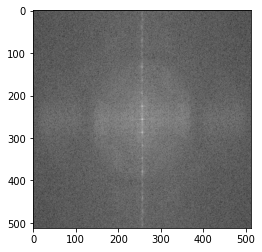

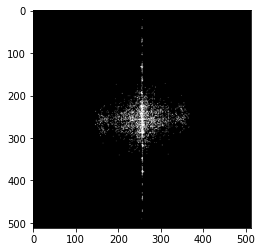

In [3]:
# SON
plt.figure()
plt.imshow(toVisualizeLogFT(computeFT(son)), cmap='gray')
plt.figure()
plt.imshow(TME1.thresholdImage(toVisualizeFT(computeFT(son)), 1e5), cmap='gray')

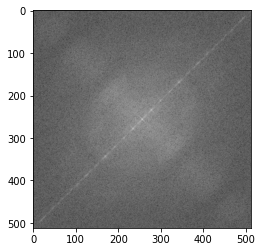

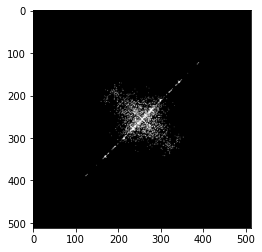

In [4]:
# SONROT
plt.figure()
plt.imshow(toVisualizeLogFT(computeFT(sonrot)), cmap='gray')
plt.figure()
plt.imshow(TME1.thresholdImage(toVisualizeFT(computeFT(sonrot)), 1e5), cmap='gray')

3. Interpretation: discuss the results obtained on thresholded FT module. What property of the Fourier transform is shown ?

**Discussion**

The threshold on the module only keeps high values of $|X(f)|$, which gives the amount of the frequency f in the image.  
Thus, thresholding gives us information on the most present frequencies in the image, which could be translated as shapes or structures in the our image.  
On `son` and `sonrot`, we emphazis on the horizontal lines of text. We do this because we'll need to know the lines' orientation later on, but removing high values could be a way to remove noise in the background.

4. Write the function `blend()` getting two images, one float parameter $\alpha\in[0,1]$, calculating $\alpha I_1+(1-\alpha)I_2$ and returning the result. 

In [5]:
def blend(I1,I2,alpha):
    """ Array**2*float -> Array """
    return alpha*I1+(1-alpha)*I2


5. Apply the previous function on images `son` and `sonrot` and $\alpha=\frac12$, compute the Fourier transform, threshold the module and visualize the result. 

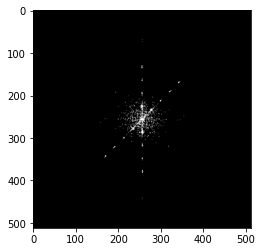

In [6]:
plt.figure()
plt.imshow(TME1.thresholdImage(toVisualizeFT(computeFT(blend(son, sonrot, 0.5))), 1e5), cmap='gray')

6. Compare the latter result with those of question 2: what property of the Fourier transform is shown? What is the behaviour of $\alpha$ in the resulting spectrum?

The Fourier Transform of `son` and `sonrot` blended together shows wel both lines orientation.  
Using the same threshold though, the amount of frequencies found is lower than what we found in question 2.  

This has to do with the Fourier Transform being linear and the $\alpha$ we used in the blending process (the original image values are lowered by half).  
Indeed, if we also multiply our threshold by $|\alpha|$, we get both previous spectrum blended :

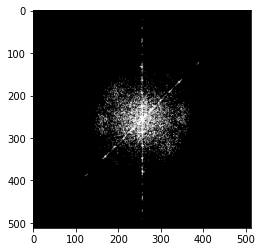

In [7]:
plt.figure()
plt.imshow(TME1.thresholdImage(toVisualizeFT(computeFT(blend(son, sonrot, 0.5))), 0.5*1e5), cmap='gray')

7. We want to determine the text orientation in image `sonrot` and produce a new image with horizontal text. Write the function `rectifyOrientation()` that:

 + computes the FT module of image given in parameter and threshold it at $3\times 10^{5}$,
 + from thresholded module determines the main orientation using the function `mainOrientation()` 
 + produces the rectified image applying a rotation with a suitable angle using `rotateImage()`

In [8]:
def mainOrientation(I):
    """ Array -> tuple[Iori,float]
        return image of orientation (32 bins) and the main orientation (degree) from a Fourier transform module
    """
    n, m = I.shape

    size = 32
    x = np.array(range(size))
    ori = np.vstack((np.cos(np.pi*x/size), np.sin(np.pi*x/size))).T

    Iori = np.zeros((n, m))
    orients = np.zeros((size))

    for i in range(1,n+1):
        for j in range(1,m+1):
            if I[i-1, j-1] > 0:
                v = np.array([j-m/2, -i + n/2])
                if i > n/2:
                    v = -v
                    prod = np.matmul(ori, v)
                    maxi = prod.max()
                    if maxi > 0:
                        imax = np.nonzero(prod == maxi)
                        Iori[i-1, j-1] = imax[0]
                        orients[imax] += 1

    maxori = np.nonzero(orients == orients.max())[0][0]
    return (Iori, 180*maxori/size-90)

def rotateImage(I,a):
    """ Array*float -> Array 
        return a rotation of angle a (degree) of image I
    """
    return np.array(Image.fromarray(I).rotate(a, expand=True, fillcolor=127))

def rectifyOrientation(I):
    I2 = TME1.thresholdImage(toVisualizeFT(computeFT(I)), 3e5)
    I2, ori = mainOrientation(I2)
    rectified = rotateImage(I, -ori)
    return rectified
 

### Testing with `son` and `sonrot`

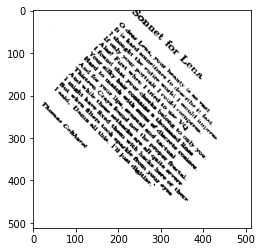

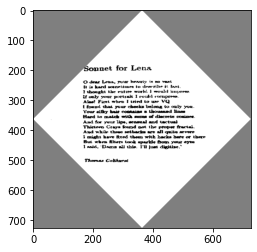

In [9]:
plt.figure()
plt.imshow(sonrot,cmap='gray')
plt.figure()
plt.imshow(rectifyOrientation(sonrot), cmap='gray')

The result seems to be good looking at first.


But rotations passed 90° can't be properly rectified, as the nearest vertical alignement would be 180°. To put it simply, skew correction through Fourier Transform only works rotated images within [-90°, +90°] interval.

Here's an example :

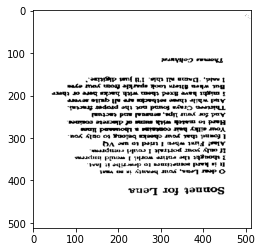

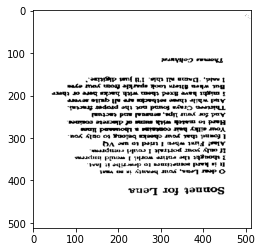

In [10]:
plt.figure()
img = rotateImage(son, 180.0)
plt.imshow(img, cmap='gray')
plt.figure()
plt.imshow(rectifyOrientation(img), cmap='gray')

### Testing with `port`

We will vary the rotation angle between +10° and +90° with increment of 10 and see wether or not the corrected image is close to the original one.

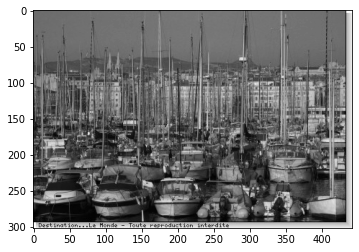

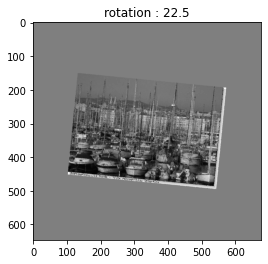

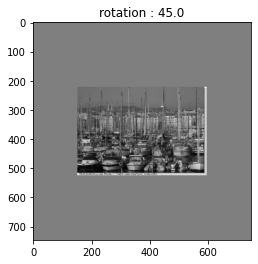

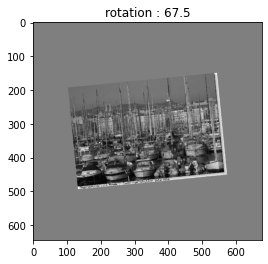

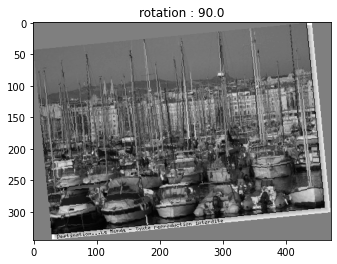

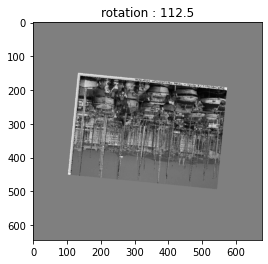

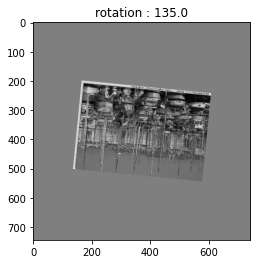

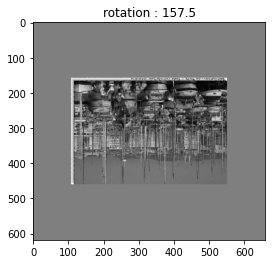

In [339]:
port = np.array(Image.open('img/port.jpg'))
plt.figure()
plt.imshow(port, cmap="gray")

i= 22.5
while i  < 180.0:
    plt.figure()
    plt.imshow(rectifyOrientation(rotateImage(port, i)), cmap="gray")
    plt.title('rotation : '+str(i))
    i+=22.5

Using the Fourier Transform alone to try and get the main orientation of a more complex picture doesn't give satisfying results. Furthermore, there seems to be a missinterpretation of the main orientation when $|\alpha| \neq 45°$.  

### Using Fourier Transform to detect and remove patterns

So far, we used a high threshold to detect patterns and structures and set orientation accordingly.  

In this section, we will use a low threshold to try and remove the patterns.

**Let's blend a picture with a grid pattern. With the right low threshold, we should be able to retrieve the important informations from our first picture**

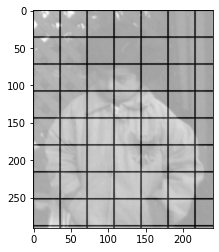

In [324]:
grid = np.array(Image.open('img/grid.jpg'))
pout = np.array(Image.open('img/pout.png'))

# Lets take a portion of the grid that matches `pout` dimensions
n,m = pout.shape
grid = grid[:n,:m]
blended = blend(grid,pout, 0.5)

plt.imshow(blended, cmap='gray')

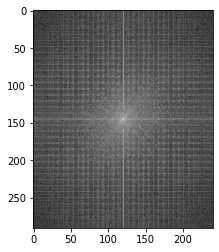

In [325]:
plt.imshow(toVisualizeLogFT(computeFT(blended)), cmap='gray')

**We want to remove the peaks without losing too much of the information at the center**

In [326]:
def thresholdFT(If, s):
    return np.where(np.abs(If)<s, If, 0)

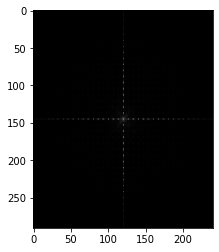

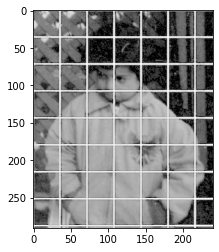

In [328]:
plt.imshow(toVisualizeFT(thresholdFT(computeFT(blended),5e5)), cmap='gray')
plt.figure()
inverseFT = np.fft.ifft2(thresholdFT(computeFT(blended), 5e5))
inverseFT = toVisualizeLogFT(inverseFT)
plt.imshow(inverseFT, cmap='gray')